<a href="https://colab.research.google.com/github/preritt/KProj/blob/master/Proposal-HighAccuracyAnalysisConv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import cifar10
from sklearn import preprocessing
from keras import losses

Using TensorFlow backend.


In [0]:

from keras.models import model_from_json

In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


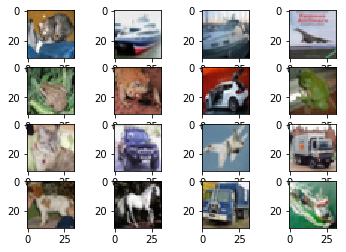

In [5]:
from matplotlib import pyplot
from scipy.misc import toimage
from keras.datasets import cifar10
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:16])


In [6]:
x_test.shape

(10000, 32, 32, 3)

In [0]:
# This function takes the entire traaining data and test data and corresponding categorical label and returns the corresponding data in class indices
def getThreeClassesTrainTest(class_indices,train_data,train_labels,test_data,test_labels):
  all_train_data = []
  all_train_data_label = []
  all_test_data = []
  all_test_data_label = []
  for ind in class_indices:
    this_class_location_train =  np.where(train_labels==ind)[0] # train_labels[train_labels == ind]
    this_class_data_train = train_data[this_class_location_train,:]
    this_class_data_train_label = train_labels[this_class_location_train]
    print(this_class_location_train)
    
    this_class_location_test = np.where(test_labels==ind)[0] #test_labels[test_labels == ind]
    this_class_data_test = test_data[this_class_location_test,:]
    this_class_data_test_label = test_labels[this_class_location_test]
    
    all_train_data.append(this_class_data_train)
    all_test_data.append(this_class_data_test)
    all_train_data_label.append(this_class_data_train_label)
    all_test_data_label.append(this_class_data_test_label)
    
  train_data_three = all_train_data[0]
  train_label_three = all_train_data_label[0]
  test_data_three = all_test_data[0]
  test_label_three = all_test_data_label[0]
  
  for j in range(1,len(class_indices)):
    train_data_three = np.concatenate((train_data_three,all_train_data[j]))
    train_label_three = np.concatenate((train_label_three,all_train_data_label[j]))

    test_data_three = np.concatenate((test_data_three,all_test_data[j]))
    test_label_three = np.concatenate((test_label_three,all_test_data_label[j]))
  print(train_label_three.shape)
  train_label_three = np.reshape(train_label_three,newshape=(-1,))
  test_label_three = np.reshape(test_label_three,newshape=(-1,))
  return train_data_three, train_label_three, test_data_three,test_label_three

### Get only three classes of data and train the model on it

In [8]:
train_three_data,train_three_label,test_three_data,test_three_label = getThreeClassesTrainTest([ 1,8,9  ],x_train,y_train,x_test,y_test)

[    4     5    32 ... 49993 49998 49999]
[    8    62    69 ... 49968 49976 49985]
[    1     2    14 ... 49963 49971 49997]
(15000, 1)


(array([5000.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 5000.,
        5000.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

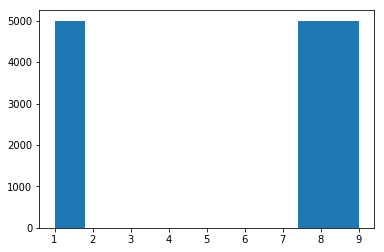

In [9]:
plt.hist(train_three_label)

(array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 1000.,
        1000.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

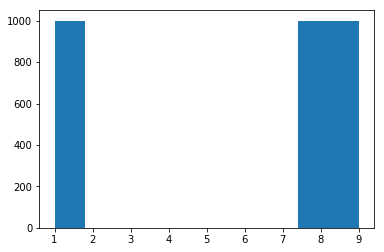

In [10]:
# test_three_label.shape
plt.hist(test_three_label)

In [0]:
train_three_data, train_three_label = shuffle(train_three_data, train_three_label )
test_three_data,test_three_label = shuffle(test_three_data,test_three_label )

In [0]:
le = preprocessing.LabelEncoder()
le.fit_transform(train_three_label)
train_three_label_cat = le.transform(train_three_label)
test_three_label_cat = le.transform(test_three_label)

In [13]:
train_three_label_cat.shape

(15000,)

In [0]:
train_three_label_one_hot = to_categorical(train_three_label_cat)
test_three_label_one_hot = to_categorical(test_three_label_cat)


In [15]:
test_three_label_one_hot.shape

(3000, 3)

In [0]:
# split train data and to create validation data
train_X,valid_X,train_ground,valid_ground = train_test_split(train_three_data,
                                                             train_three_label_one_hot,
                                                             test_size=0.2,
                                                             random_state=13)

In [0]:
num_classes = test_three_label_one_hot.shape[1]

In [0]:
x, y = 32, 32
inChannel = 3
input_img = Input(shape = (x, y, inChannel))
ep = 10 
weight_decay = 1e-4

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [0]:
def cifar10Classifier(input_img):
  
  conv1 = (Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:], activation='elu'))(input_img)
  conv1 = BatchNormalization()(conv1)
  conv1 = (Conv2D(32, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv1)
  conv1 = BatchNormalization()(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
  drop1= Dropout(.2)(pool1)

  conv2 = (Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop1)
  conv2 = BatchNormalization()(conv2)
  conv2 = (Conv2D(64, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv2)
  conv2 = BatchNormalization()(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #14 x 14 x 32
  drop2= Dropout(.3)(pool2)

  conv3 = (Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop2)
  conv3 = BatchNormalization()(conv3)
  conv3 = (Conv2D(128, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv3)
  conv3 = BatchNormalization()(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #14 x 14 x 32
  drop3= Dropout(.4)(pool3)

  flat = Flatten()(drop3)
  out = Dense(num_classes, activation='softmax')(flat)
  
  return out

In [21]:
model = Model(input_img, (cifar10Classifier(input_img)))
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_three_data)
 
#training
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

model.compile(loss=losses.categorical_crossentropy, optimizer=opt_rms, metrics=['accuracy'])

model.summary()
 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxP

In [22]:
loaded_model_high = keras.models.load_model('high_acc_complete_model.h5')

Instructions for updating:
Use tf.cast instead.


In [0]:

for l1,l2 in zip(model.layers[0:],loaded_model_high.layers[0:]):
    l1.set_weights(l2.get_weights())

In [0]:
mcp_save = ModelCheckpoint('weights.hdf5', save_best_only=True, monitor='val_loss', mode='auto')

train_X,valid_X,train_ground,valid_ground

In [0]:
model.fit_generator(datagen.flow(train_X, train_ground, batch_size=batch_size),\
                    steps_per_epoch=train_X.shape[0] // batch_size,epochs=20,\
                    verbose=1,validation_data=(valid_X,valid_ground),
                    shuffle = True,callbacks=[mcp_save,LearningRateScheduler(lr_schedule)])
#save to disk
model_json = model.to_json()
with open('modelHighAcc.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('modelHighAcc.h5') 
model.save('high_acc_complete_modelConv2d_2.h5')


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
187/187 [==============================] - 16s 84ms/step - loss: 1.1731 - acc: 0.6251 - val_loss: 1.0542 - val_acc: 0.6167
Epoch 2/20
187/187 [==============================] - 11s 57ms/step - loss: 0.7915 - acc: 0.7389 - val_loss: 0.9263 - val_acc: 0.7047
Epoch 3/20
187/187 [==============================] - 11s 57ms/step - loss: 0.6515 - acc: 0.7970 - val_loss: 0.5510 - val_acc: 0.8387
Epoch 4/20
187/187 [==============================] - 11s 57ms/step - loss: 0.6124 - acc: 0.8241 - val_loss: 0.5202 - val_acc: 0.8293
Epoch 5/20
187/187 [==============================] - 11s 59ms/step - loss: 0.5732 - acc: 0.8409 - val_loss: 0.4492 - val_acc: 0.8747
Epoch 6/20
187/187 [==============================] - 11s 59ms/step - loss: 0.5418 - acc: 0.8535 - val_loss: 0.4929 - val_acc: 0.8800
Epoch 7/20
187/187 [==============================] - 11s 59ms/step - loss: 0.4937 - acc: 0.8684 - val_loss: 0.3795 - val_acc: 0.8857
Epoch 8/20
187

In [0]:
model.load_weights('weights.hdf5')

In [25]:
model.evaluate(valid_X, valid_ground, verbose=0)

[0.2548428738514582, 0.9463333334922791]

In [26]:
#testing
test_eval = model.evaluate(test_three_data, test_three_label_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.28451347130537036
Test accuracy: 0.9356666666666666


In [0]:
test_three_data.shape

(3000, 32, 32, 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


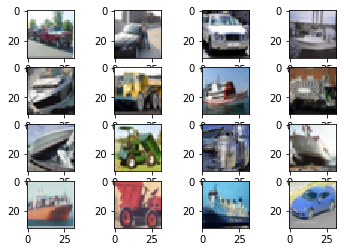

In [0]:
# show_imgs(test_three_data[:,1])
show_imgs(test_three_data[:16])

In [0]:
def getDIScoreOfLayer(layer_output, true_labels):
  # computeScatterMatrix
  rho = 1e-6
  mu = layer_output.mean(axis=0)
#   print(mu.shape)
  mu = mu.reshape((1,-1))
  centered_data = layer_output - mu
  S_bar = np.matmul(centered_data.T,centered_data)
  # compute between class matrix
  total_classes = true_labels.max()
  S_B = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  S_W = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  unique_classes = np.unique(true_labels)
  unique_classes_list = np.ndarray.tolist(unique_classes)
  for l in unique_classes_list:
    class_l_index = np.where(true_labels == l)
    class_l_output = layer_output[class_l_index[0],:]
    mu_l = class_l_output.mean(axis=0)
    mu_l = mu_l.reshape((1,-1))
    total_examples_this_class = class_l_index[0].shape   
    ss = mu_l - mu
#     print(total_examples_this_class[0])
#     print(c+1)
    S_B = S_B + total_examples_this_class[0]*np.matmul((mu_l - mu).T,(mu_l - mu))

  DI_Score = np.trace(np.matmul(np.linalg.inv(S_bar + rho*np.eye(S_bar.shape[0])),S_B))
  return DI_Score

In [0]:
def getDIScoreOfLayerCNNLayer(cnn_outputs, true_labels):
  # computeScatterMatrix
  number_of_filters = cnn_outputs.shape[3]
  cnn_di_scores = []
  for filt in range(0,number_of_filters):
    outputs_filter = cnn_outputs[:,:,:,filt]
    outputs_filter_reshaped = np.reshape(outputs_filter, newshape=(cnn_outputs.shape[0],-1))
    this_filter_score = getDIScoreOfLayer(outputs_filter_reshaped, true_labels)
    cnn_di_scores.append(this_filter_score)
  return cnn_di_scores

In [29]:
# layer_name
valid_X.shape

(3000, 32, 32, 3)

In [0]:
# train_three_data, train_three_label

In [0]:
layer_name = 'conv2d_4'
get_cnn1_output_function = K.function([model.layers[0].input],
                                  [model.get_layer(layer_name).output])   #get_layer test_three_label
cnn1_output = get_cnn1_output_function([train_three_data])[0]

In [48]:
cnn1_output.shape

(15000, 8, 8, 128)

In [49]:
cnn1_output.shape

(15000, 8, 8, 128)

In [50]:
np.ndarray.tolist(np.unique(test_three_label))

[1, 8, 9]

In [0]:
# valid_ground_cat = np.argmax(train_ground, axis=1)
# # valid_ground_cat
# valid_ground.shape

In [0]:

di_scores = getDIScoreOfLayerCNNLayer(cnn1_output, train_three_label)

Mean of DI SCore:  0.6268005864444735
STD of DI Score:  0.1603453525988464
MAX of DI Score:  0.8991346992362158


Text(0.5, 1.0, 'DI score - Data - D_H, Network -N_H, Conv_4')

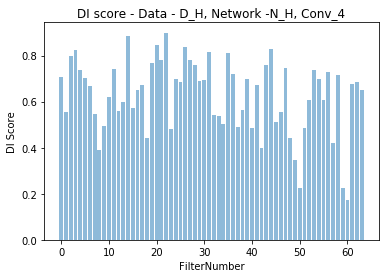

In [105]:
y_pos  = np.arange(len(di_scores))
plt.bar(y_pos, di_scores, align='center', alpha=0.5)
plt.xlabel('FilterNumber')
plt.ylabel('DI Score')

print('Mean of DI SCore: ',np.mean(di_scores))
print('STD of DI Score: ', np.std(di_scores))
print('MAX of DI Score: ', np.max(di_scores))
plt.title('DI score - Data - D_H, Network -N_H, Conv_4')

## DI on different data

1.   List item
2.   List item



In [54]:
labelsToUse = [0,3,5]
train_three_data_low,train_three_label_low,test_three_data_low,test_three_label_low = getThreeClassesTrainTest(labelsToUse,x_train,y_train,x_test,y_test)

[   29    30    35 ... 49941 49992 49994]
[    9    17    21 ... 49979 49982 49983]
[   27    40    51 ... 49964 49980 49988]
(15000, 1)


In [0]:

# split train data and to create validation data
train_X_low,valid_X_low,train_ground_low,valid_ground_low = train_test_split(train_three_data_low,
                                                             train_three_label_low,
                                                             test_size=0.2,
                                                             random_state=13)

In [91]:
layer_name = 'conv2d_4'
get_cnn1_output_function_low = K.function([model.layers[0].input],
                                  [model.get_layer(layer_name).output])   #get_layer test_three_label
cnn1_output_low = get_cnn1_output_function_low([train_three_data_low])[0]
cnn1_output_low.shape

(15000, 16, 16, 64)

In [0]:
di_scores_low = getDIScoreOfLayerCNNLayer(cnn1_output_low, train_three_label_low)


Mean of DI SCore:  0.4930362544265075
STD of DI Score:  0.11267728684128724
MAX of DI Score:  0.6655810041280735


Text(0.5, 1.0, 'DI score - Data - D_L, Network -N_H, Conv_4')

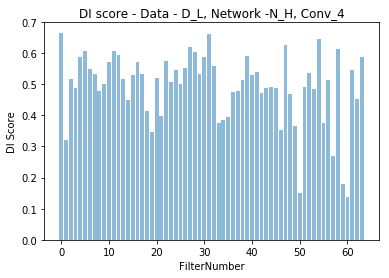

In [106]:
y_pos  = np.arange(len(di_scores_low))
plt.bar(y_pos, di_scores_low, align='center', alpha=0.5)
plt.xlabel('FilterNumber')
plt.ylabel('DI Score')
plt.title(str(labelsToUse))

print('Mean of DI SCore: ',np.mean(di_scores_low))
print('STD of DI Score: ', np.std(di_scores_low))
print('MAX of DI Score: ', np.max(di_scores_low))
plt.title('DI score - Data - D_L, Network -N_H, Conv_4')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

In [0]:
# # not working
# mat_save = {'diScore': di_scores, 'conv2d_1': cnn1_output, 'trueLabel':train_three_label}
# savemat('LowAccuracyConv2d_1MatrixMethod', mat_save) 

In [0]:
sum(di_scores)

15.558955910452138

In [0]:
max(di_scores)

0.6730249143024407

In [0]:
from scipy.io import savemat
